# Introduction à l'intelligence artificielle - Projet

**Réalisé par Timothée De Decker.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from scipy.optimize import minimize
from scipy.linalg import norm
import torch as torch
import torch.nn as nn
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "C:/Users/timot/Documents/Intro_IA/data/"

In [3]:
# Importation des données
# Celles-ci seront rangées dans un dictionnaire dont les clés correspondent aux lettres A B C
x_train = {}
y_train = {}
x_test = {}
y_test = {}

for letter in ['A', 'B', 'C']:
    train = pd.read_csv(path+f"train{letter}", sep=' ', header=None)
    test = pd.read_csv(path+f"test{letter}", sep=' ', header=None)
    
    # Séparation des variables explicatives et de la cible
    x_train[letter] = train.iloc[:, :2].to_numpy()
    y_train[letter] = train.iloc[:, 2].to_numpy()
    x_test[letter] = test.iloc[:, :2].to_numpy()
    y_test[letter] = test.iloc[:, 2].to_numpy()

## Classification

Dans ce qui suit, on notera :
- $X$ et $Y$ les variables aléatoires correspondant respectivement aux _features_ et à la cible ;
- $n$ la taille de l'échantillon et $n_k$ la taille de la classe $k \in \{0,1\}$ ;
- $y_i \in \{0,1\}$ la classe d'appartenance de l'individu $i$ ;
- $x_i = (x_i^1, x_i^2) \in \mathbb{R}^2$ le vecteur des valeurs de $X$ observées pour l'individu $i$ (tous les vecteurs sont disposés en colonne par défaut) ;
- $M_{X}=(1, x_1^T, ..., x_n^T) \in\mathbb{M}_{n,2}$ la matrice contenant le couple de valeurs prises par $X$ pour chaque individu plus une colonne de 1 pour le calcul du biais ;
- $y =(y_1, ...,y_n)\in \{0,1\}^n$ le vecteur indiquant la classe (la valeur obervée de $Y$) de chaque individu ;
- $E_k$ l'ensemble des individus appartenant à la classe $k$.

### Analyse linéaire discriminante

On considère le modèle suivant :

$$Y \sim \mathcal{B}(\pi),\quad X|Y=k \sim \mathcal{N}(\mu_k, \Sigma)$$

avec $\mathcal{B}$ et $\mathcal{N}$ représentant respectivement la loi binomiale et la loi normale.

#### Estimateur du maximum de vraisemblance de $\theta=(\pi,\mu_0, \mu_1, \Sigma)$

**Estimateur de $\pi$**

La log-vraisemblance liée à une distribution de Bernouilli de paramètre $\pi$ s'écrit comme suit :

$$L(\pi)=\sum_{i=1}^n y_i\ln\pi+(1-y_i)\ln(1-\pi)$$

Sa dérivée par rapport à $\pi$ vaut:

$$\frac{\delta L(\pi)}{\delta \pi}=\sum_{i=1}^{n} \big(\frac{y_i}{\pi}-\frac{1-y_i}{1-\pi}\big)=\sum_{i=1}^{n} \frac{y_i-\pi}{\pi(1-\pi)}$$

Le maximum de vraisemblance, s'il existe et est unique, est atteint lorsque cette dérivée s'annule ; on résoud donc l'équation suivante :

$$\frac{\delta L(\pi)}{\delta \pi}=0\Longleftrightarrow \sum_{i=1}^{n} y_i-n\pi=0\Longleftrightarrow \hat{\pi}_\textrm{EMV}=\frac{\sum_{i=1}^n y_i}{n} = \frac{n_1}n$$

On note que l'EMV du paramètre $\pi$ correspond à la proportion d'individus appartenant à la classe 1 dans l'échantillon.

**Estimateur de $\mu_k$**

On suppose ici que $k$ est fixé, ce qui implique que nous n'utiliserons plus la totalité de l'échantillon de taille $n$ comme précédemment mais le sous-échantillon $E_k$ de taille $n_k$ des observations appartenant à la classe $k$. 

Ces observations sont distribuées selon une loi gaussienne multivariée de paramètres $\mu_k$ et $\Sigma$. Calculons la log-vraisemblance de cet échantillon par rapport à $mu_k$ (le facteur de normalisation de la gaussienne est donc traité comme une constante) :

$$L(\mu_k)=-\frac{1}{2}\sum_{i\in E_k} (x_i-\mu_k)^T\Sigma^{-1}(x_i-\mu_k) + C = -\frac{1}{2}\sum_{i\in E_k} (x_i^T\Sigma^{-1}x_i -\underbrace{\mu_k^T\Sigma^{-1}x_i  -x_i^T\Sigma^{-1}\mu_k}_{\textrm{transposées mais scalaires donc égalité}} + \mu_k^T\Sigma^{-1}\mu_k) + C=-\frac{1}{2}\sum_{i\in E_k} (x_i^T\Sigma^{-1}x_i -2\mu_k^T\Sigma^{-1}x_i+\mu_k^T\Sigma^{-1}\mu_k) + C$$

Connaissant le résultat suivant sur le calcul de gradient, pour $x \in\mathbb{R}^p$ et $A$ une matrice $p\times p$ symétrique:

$$\nabla_x x^TAx=2Ax \quad\textrm{}$$

et sachant qu'une matrice de covariance tout comme son inverse est symétrique, la dérivée (le gradient) de $L(\mu_k)$ se calcule comme suit:

$$\nabla_{\mu_k} L = -\frac{1}{2}\sum_{i\in E_k} 2\Sigma^{-1}(x_i - \mu_k) = -\Sigma^{-1}\sum_{i\in E_k} (x_i-\mu_k)$$

On peut maintenant calculer la valeur de $\mu_k$ qui maximise la log-vraisemblance :

$$
\begin{array}{rcl}
\nabla_{\mu_k}=0 & \Longleftrightarrow & \Sigma^{-1}\sum_{i\in E_k} (x_i-\mu_k)=0 \\
& \Longleftrightarrow & \sum_{i\in E_k} (x_i-\mu_k)=0 \;\textrm{[car $\Sigma$ est définie positive]} \\
& \Longleftrightarrow & \sum_{i\in E_k} x_i=n_k\mu_k \\
& \Longleftrightarrow & \hat{\mu}_{k\textrm{EMV}}=\frac{\sum_{i\in E_k} x_i}{n_k}
\end{array}
$$

La moyenne $\mu_k$ est donc estimée par le barycentre conditionnel empirique des variables relativement au groupe $k$.

**Estimateur de $\Sigma$**

On reprend l'expression de la log-vraisemblance précédente en réintégrant les termes dépendants de $\Sigma$ laissés dans la constante.

$$L(\Sigma)=-\frac{1}{2}\big(n_k\ln{|\Sigma|}+\sum_{i\in E_k} (x_i-\mu_k)^T\Sigma^{-1}(x_i-\mu_k)\big) + C_2$$

Profitant que $|\Sigma^{-1}| = \frac{1}{|\Sigma|}$, on peut réécrire $\ln{|\Sigma|}=-\ln{|\Sigma^{-1}|}$ pour exprimer la log-vraisemblance uniquement en fonction de $\Sigma^{-1}$ :

$$L(\Sigma)=\frac{1}{2}\big(n_k\ln{|\Sigma^{-1}|}-\sum_{i\in E_k} (x_i-\mu_k)^T\Sigma^{-1}(x_i-\mu_k)\big) + C_2$$

Le gradient par rapport à $\Sigma^{-1}$ se calcule alors en profitant de certaines des propriétés de la trace et du déterminant d'une matrice carrée :

$$
\begin{array}{rcl}
\nabla_{\Sigma^{-1}} L &=& \frac{1}{2} \Big( n_k\Sigma^T - \sum_{i\in E_k} \nabla_{\Sigma^{-1}} tr\,\big(\underbrace{(x_i-\mu_k)^T \Sigma^{-1} (x_i-\mu_k) }_{\textrm{scalaire}}\big)\Big) \qquad \textrm{car $\nabla_A\ln|A| = (A^{-1})^T$ et tr$(a) = a$ si $a \in \mathbb{R}$}
\\ &=& \frac{1}{2} \Big( n_k\Sigma^T - \nabla_{\Sigma^{-1}}tr\,\big(\Sigma^{-1}\sum_{i\in E_k}(x_i-\mu_k) (x_i-\mu_k)^T\big)\Big) \qquad \textrm{par linéarité et commutativité de la trace}
\\ &=& \frac{1}{2} \Big( n_k\Sigma^T - \big(\sum_{i\in E_k}(x_i-\mu_k) (x_i-\mu_k)^T\big)^T\Big) \qquad \textrm{car $\nabla_A\,tr(AB)=B^T$}
\end{array}
$$

On ramène une nouvelle fois cette expression à $0$ pour trouver l'estimateur :

$$
\begin{array}{rcl}
\nabla_{\Sigma^{-1}} L = 0 & \Longleftrightarrow & \big(\nabla_{\Sigma^{-1}} L\big)^T = 0
\\ & \Longleftrightarrow & n_k\Sigma - \sum_{i\in E_k}(x_i-\mu_k) (x_i-\mu_k)^T = 0
\\ & \Longleftrightarrow & \Sigma_k = \frac{\sum_{i\in E_k}(x_i-\mu_k) (x_i-\mu_k)^T}{n_k}
\end{array}
$$

Cette expression suffirait si notre échantillon se limitait à $E_k$ et si $\mu_k$ était unique. Dans notre cas cependant, $\mu_k$ se comporte comme une variable aléatoire valant 1 avec une probabilité $\pi$ et $0$ avec une probabilité $1-\pi$ et on dispose uniquement pour l'instant d'un estimateur de la covariance conditionnelle à chaque groupe.

Il reste donc à déconditionner notre estimateur en calculant son espérance ; on utilisera pour cela les estimateurs de $\pi$ et de $\mu_k$ trouvés plus haut :

$$
\hat{\Sigma}_{\textrm{EMV}} = \hat{\pi}\Sigma_1+(1-\hat{\pi})\Sigma_0 = \frac{n_1}{n}\Sigma_1 + \frac{n_0}{n}\Sigma_0 = \frac{1}{n}\big(\sum_{i\in E_1}(x_i-\mu_1) (x_i-\mu_1)^T + \sum_{i\in E_0}(x_i-\mu_0) (x_i-\mu_0)^T\big)
$$

On reconnaît la formule de la variance intraclasse (variance *within*, par opposition à la variance *between*, interclasses) qui consiste en la moyenne des variances de chaque classe.

#### Expression de $P(Y=1|X=x)$

La formule de Bayes permet de retrouver la probabilité de $Y$ sachant $X$ à partir de celles que nous connaissons déjà :

$$P(Y=1|X=x)=\frac{P(Y=1\cap X=x)}{f_X(x)}=\frac{P(Y=1)f_{X|Y=1}(x)}{\sum_{k=0}^{1}P(Y=k)f_{X|Y=k}(x)}$$

Pour plus de simplicité, on recourt à l'écriture $p(x;y)$ pour désigner indifféremment la probabilité ou la densité conditionnelle de X sachant Y, selon la nature de $X$.


$$
\begin{array}{rcl}
p(y=1;x) & = & \dfrac{\pi p(x;y=1)}{\pi p(x;y=1)+(1-\pi)p(x;y=0)} \\ & = & \dfrac{1}{1+\dfrac{1-\pi}{\pi}\dfrac{p(x;y=0)}{p(x;y=1)}}
\end{array}
$$

Calculons à part le rapport des deux probabilités conditionnelles :

$$
\begin{array}{rcl}
\dfrac{p(x;y=0)}{p(x;y=1)} & = & \exp\Big(-\frac{1}{2}\big((x-\mu_0)^T\Sigma^{-1}(x-\mu_0)-(x-\mu_1)^T\Sigma^{-1}(x-\mu_1)\big)\Big) \qquad \textrm{[on distribue et on refactorise]}\\
& = & \exp\Big(-\frac{1}{2}\big(\underbrace{x^T\Sigma^{-1}(\mu_1-\mu_0) + (\mu_1-\mu_0)^T\Sigma^{-1}x}_{\textrm{transposées de scalaires donc égalité}} + \mu_0^T \Sigma^{-1}\mu_0 - \mu_1^T \Sigma^{-1}\mu_1\big)\Big) \\
& = & \exp\Big( - \Big( \frac{1}{2} \big(\mu_0^T \Sigma^{-1}\mu_0 - \mu_1^T \Sigma^{-1}\mu_1\big) + (\mu_1-\mu_0)^T\Sigma^{-1}x \Big)\Big)
\end{array}
$$

En écrivant $\frac{1-\pi}{\pi}$ sous forme exponentielle, on aura de plus :

$$
\begin{array}{rcl}
\dfrac{1}{1+\dfrac{1-\pi}{\pi}\dfrac{p(x;y=0)}{p(x;y=1)}} & = & \exp\Big( - \Big( \frac{1}{2} \big(\mu_0^T \Sigma^{-1}\mu_0 - \mu_1^T \Sigma^{-1}\mu_1\big) + (\mu_1-\mu_0)^T\Sigma^{-1}x \Big) + \ln (\frac{1-\pi}{\pi})\Big) \\ & = &\exp\Big( - \Big( \underbrace{\frac{1}{2} \big(\mu_0^T \Sigma^{-1}\mu_0 - \mu_1^T \Sigma^{-1}\mu_1\big) - \ln (\frac{1-\pi}{\pi})}_{a \in \mathbb{R}} + \underbrace{(\mu_1-\mu_0)^T\Sigma^{-1}}_{b^T \in \mathbb{R}^2} x \Big)\Big) \\
\end{array}
$$

La probabilité de $Y=1|X$ s'écrit donc sous la forme $\dfrac{1}{1+e^{-z}}$ avec $z = a + b^T x$, ce qui correspond exactement à la forme du paramètre de la distribution de Bernouilli dans le modèle de régression logistique.

#### Implémentation et représentation graphique

Nous commençons par estimer la valeur de $\Theta = (\pi, \mu_0, \mu_1, \Sigma)$ pour chacun des trois jeu de données disponibles.

In [4]:
# On prévoit des dictionnaires pour enregistrer nos estimations
pi = {}
mu0 = {}
mu1 = {}
sigma = {}

for letter in ['A', 'B', 'C']:
    
    # Récupération des variables et de la cible
    x = x_train[letter]
    y = y_train[letter]
    
    # Sélection des individus de chaque groupe
    x0 = x[y==0]
    x1 = x[y==1]
    
    # Le prior se calcule comme la proportion du groupe 1 dans l'échantillon total
    pi[letter] = np.mean(y)
    
    # mu_i représente le couple des moyennes des deux variables dans le groupe i
    mu0[letter] = np.mean(x0, 0)
    mu1[letter] = np.mean(x1, 0)
    
    # Enfin la matrice de covariance se calcule comme la moyenne des variances conditionnelles
    sigma[letter] = ((x0-mu0[letter]).T@(x0-mu0[letter]) + (x1-mu1[letter]).T@(x1-mu1[letter]))/len(x)
    
    # On imprime les estimations des Sigma pour un meilleur affichage...
    print(f'Covariance estimée pour le dataset {letter} : \n{sigma[letter]}\n')

# ... et on montre les autres paramètres estimés sous forme de tableau
pd.DataFrame([pi, mu0, mu1]).T.rename(columns={0:'Pi', 1:'mu1', 2:'mu2'})


Covariance estimée pour le dataset A : 
[[0.58821974 0.13912842]
 [0.13912842 0.81959919]]

Covariance estimée pour le dataset B : 
[[1.64391088 0.70139847]
 [0.70139847 2.0605845 ]]

Covariance estimée pour le dataset C : 
[[ 1.27823018 -0.06243809]
 [-0.06243809  1.66584186]]



Pi                                       mu1  \
A      0.48   [10.73248858175118, 10.939833671265887]   
B      0.55   [10.582567563757108, 11.17169817633428]   
C  0.416667  [10.619227299520304, 10.838686532698695]   

                                       mu2  
A  [11.032645807210315, 5.992940534187141]  
B  [11.247576623138668, 6.095282997199408]  
C  [11.184631987310057, 6.042493154762398]

L'équation $P(Y=1|X=x)=\frac{1}{2}$ correspond à la frontière de décision pour le critère bayésien $\max_{k}P(Y=k|X=x)$ lorsque $k$ admet deux modalités : si $P(y_i=1|x_i) > \frac{1}{2}$, l'observation sera classée dans le groupe 1, sinon dans le groupe 2. 

Essayons de traduire un peu cette équation :

$$
\begin{array}{rcl}
\dfrac{1}{1+e^{-z}} = \dfrac{1}{2} & \Longleftrightarrow & z = 0 \\
& \Longleftrightarrow & a + b^T x = 0 \\
& \Longleftrightarrow & \Big(\frac{1}{2} \big(\mu_0^T \Sigma^{-1}\mu_0 - \mu_1^T \Sigma^{-1}\mu_1\big) - \ln (\frac{1-\pi}{\pi})\Big) + (\mu_1-\mu_0)^T\Sigma^{-1} x = 0
\end{array}
$$

Il devrait être possible de trouver les solutions $x^*$ à cette équation pour ensuite exprimer l'un des termes du couple en fonction de l'autre et tracer une frontière exacte. 

Pour plus de simplicité cependant, nous allons représenter graphiquement les zones correspondant à chaque classe d'après notre modèle associé à la règle de décision bayésienne : la délimitation de ces deux zones correspondra à la fonction définie par $P(Y=1|X=x)=\frac{1}{2}$.

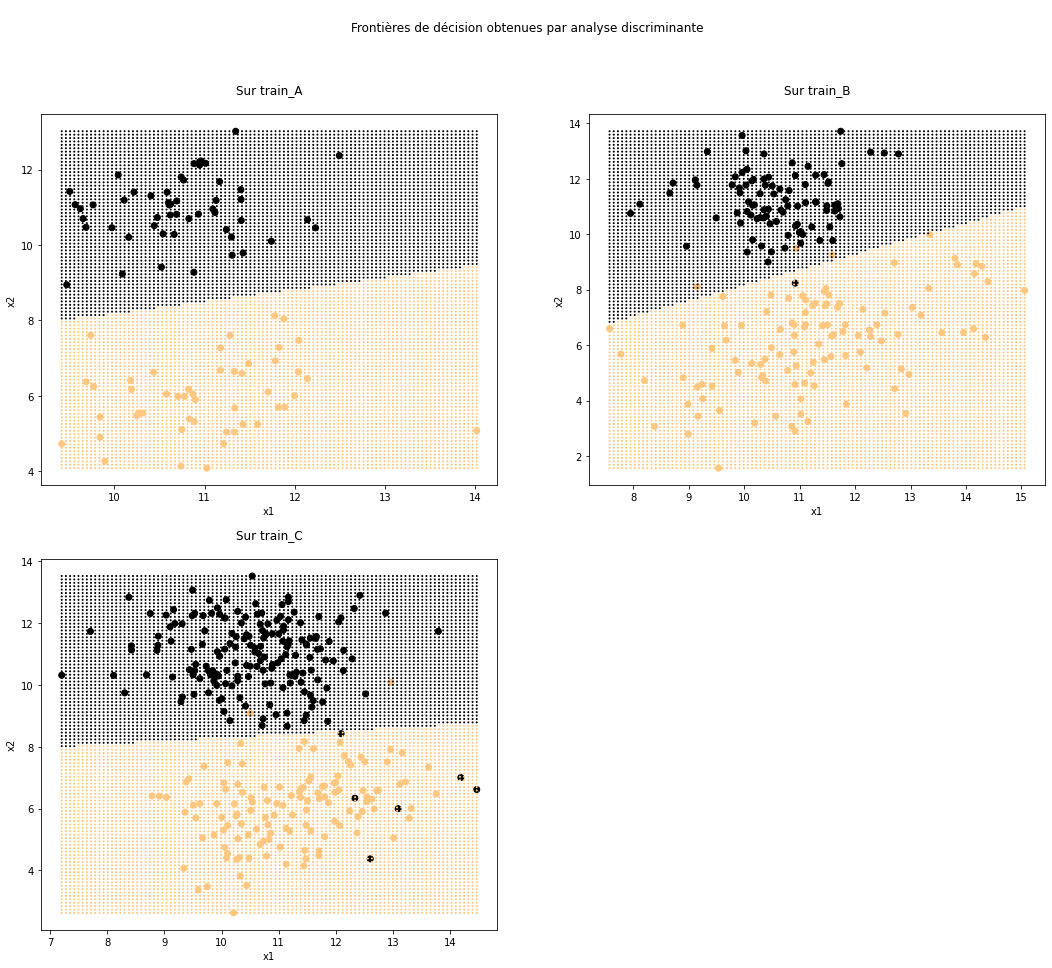

In [5]:

lda = lambda x, l: 0.5*(mu0[l].T @ np.linalg.inv(sigma[l]) @ mu0[l]\
                             - mu1[l].T @ np.linalg.inv(sigma[l]) @ mu1[l]\
                             - np.log(1/pi[l]-1))\
                             + (mu1[l]-mu0[l]).T @ np.linalg.inv(sigma[l]) @ x.T

plt.figure(figsize=(18,15))

for i, letter in enumerate(['A', 'B', 'C']):
    
    plt.subplot(2,2,i+1)
    
    # Récupération des observations et des estimations
    x = x_train[letter]
    y = y_train[letter]
    
    # Nuage de points
    plt.scatter(x[:, 0], x[:, 1], c = y, cmap='copper')
    
    # Création d'une grille de coordonnées
    x1 = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
    x2 = np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 100)
    grid1, grid2 = np.meshgrid(x1, x2)
    grid = np.array([np.ravel(grid1), np.ravel(grid2)]).T
    
    # Prédiction sur l'ensemble des points de la grille
    crit = lda(grid, letter) > 0
    
    
    # Visualisation de la frontière de décision
    plt.scatter(grid[:,0], grid[:,1], c = crit, cmap='copper', s=1)
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Sur train_{letter}\n')

plt.suptitle('\nFrontières de décision obtenues par analyse discriminante')
plt.show()

### Régression logistique

#### Estimation des coefficients

Soit $Y$ une variable aléatoire à valeurs dans $\{0, 1\}$, $X$ un vecteur aléatoire, $w$ un vecteur réel de même dimension et $b$ un réel.

Le modèle de régression logistique s'écrit:

$$Y|X=x \sim \mathcal{B}\big( g(b + x^T w)\big) \qquad\textrm{avec $g(t)=\frac{1}{1+e^{-t}}$ la fonction logit}$$

Autrement dit, on considère que la variable cible $y_i$ pour une observation donnée $x_i$ vaudra 1 avec une probabilité dépendant de $f(x_i) = b + w^T x_i = b + w_1 x_i^1 + w_2 x_i^2$. 

En ajoutant une colonne de $1$ à la matrice de nos observations, on peut réécrire cette fonction $f(x_i) = \beta^T x'_i $, avec $\beta^T = (b, w_1, w_2)$ et ${x'}_{i}^{T} = (1, x_i^1, x_i^2)$.

L'estimation du vecteur de coefficients $\beta$ s'obtient en minimisant une fonction de perte, en l'occurrence **l'erreur de cross-entropy** qui correspond à l'opposée de la log-vraisemblance du modèle :

$$E(\beta) = -L(\beta) = -\sum_{i=1}^n \Big( y_i \ln g(\beta^T {x'}_{i}) + (1+y_i) \ln \big(1 - g(\beta^T {x'}_{i}) \big) \Big)$$

Il n'existe pas de solution analytique à ce problème d'optimisation : il faut donc recourir à un algorithme d'optimisation itératif.

In [6]:
# Fonction logit
g = lambda t : 1/(1 + np.exp(-t))

# On initie aléatoirement des coefficients de départ pour l'optimisation
init = np.random.randn(3)

# Dictionnaire des vecteurs de coefficients obtenus pour chaque dataset
beta_log = {}

for letter in ['A', 'B', 'C']:
    
    # Récupération du dataset concerné
    x = x_train[letter]
    y = y_train[letter]
    
    # Ajout d'une colonne de 1 aux données pour le calcul du biais
    x_prim = np.concatenate([np.ones((len(x), 1)), x], axis=1)
    
    # Implémentation de la cross-entropy pour l'optimisation
    binary_cross = lambda beta: -np.sum([y[i]*np.log(g(np.dot(x_prim[i].T, beta))) + (1-y[i])*np.log(1-g(np.dot(x_prim[i].T, beta))) for i in range(len(x))])
    
    # Optimisation
    beta = minimize(binary_cross, init, method='Nelder-Mead').x
    
    # Enregistrement des coefficients estimés
    beta_log[letter] = beta

# Affichage de l'ensemble des résultats
pd.DataFrame(beta_log).T.rename(columns={0:'beta_0', 1:'beta_1', 2:'beta_2'})

beta_0    beta_1    beta_2
A   2.337689  4.645134 -6.044891
B  13.430116  1.842396 -3.713934
C  18.806952 -0.276931 -1.914192

#### Représentation graphique

L'équation $P(Y=1|X=x)=\frac{1}{2}$ correspond à la frontière de décision pour le critère bayésien $\max_{k}P(Y=k|X=x)$ lorsque $k$ admet deux modalités : si $P(y_i=1|x_i) > \frac{1}{2}$, l'observation sera classée dans le groupe 1, sinon dans le groupe 2. 

Les points solutions de l'équation ont donc autant de chances d'appartenir au groupe 1 qu'au groupe 2. Géométriquement, leur projection sur l'espace des variables $(x_1, x_2)$ dessine une droite dont nous allons calculer l'équation : 

$$
\begin{array}{rcl}
P(Y=1|X=x) = \frac{1}{2} & \Longleftrightarrow & g(b + (x_1, x_2)^Tw) = \frac{1}{2} \\
& \Longleftrightarrow & g(b + w_1 x_1 + w_2 x_2) = \frac{1}{2} \\
& \Longleftrightarrow & 1+\exp \big( -(b + w_1 x_1 + w_2 x_2) \big) = 2 \\
& \Longleftrightarrow & -b - w_1 x_1 - w_2 x_2 = 0 \\
& \Longleftrightarrow & x_2 = -\frac{b}{w_2} - \frac{w_1}{w_2} x_1\\
\end{array}
$$

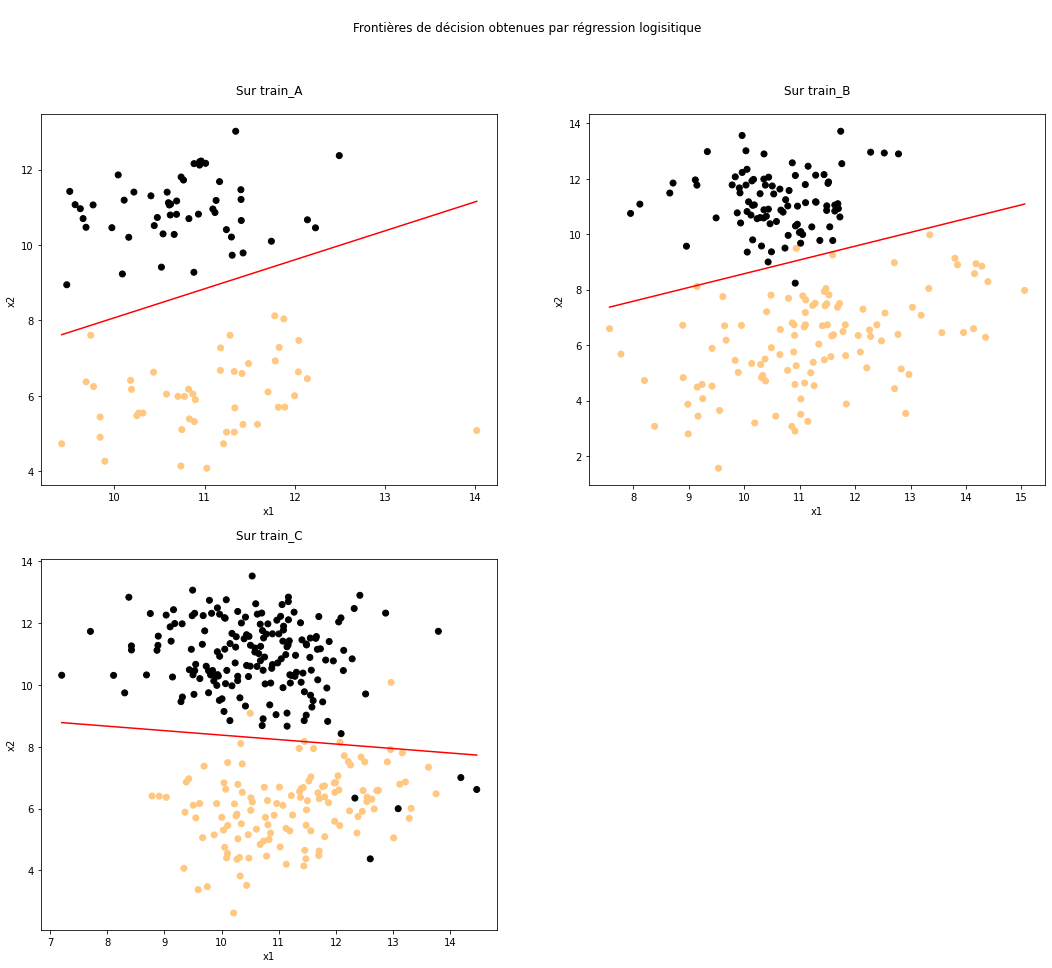

In [7]:
plt.figure(figsize=(18,15))

for i, letter in enumerate(['A', 'B', 'C']):
    
    plt.subplot(2,2,i+1)
    # Récupération des observations et des estimations
    x = x_train[letter]
    y = y_train[letter]
    beta = beta_log[letter]
    
    # Nuage de points
    plt.scatter(x[:, 0], x[:, 1], c = y, cmap='copper')
    
    # Abscisse
    x1 = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
    
    # Calcul de la droite de décision
    x2 = (-beta[0] - x1*beta[1]) / beta[2] 
    
    # Ajout de la frontière
    plt.plot(x1, x2, color='red')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Sur train_{letter}\n')

plt.suptitle('\nFrontières de décision obtenues par régression logisitique')
plt.show()

### Régression linéaire

#### Estimation des coefficients

Soit $Y$ une variable aléatoire réelle, $X$ un vecteur aléatoire, $w$ un vecteur réel de même dimension et $b$ un réel.

Le modèle de régression linéaire s'écrit:

$$Y|X=x \sim \mathcal{N}(b + x^T w,\; \sigma^2 I_n)$$

Dans son usage classique, ce modèle sert à prédire la valeur d'une variable réelle à partir d'une ou plusieurs autres variables explicatives, il semble donc de prime abord inadapté à un problème de classification binaire dans lequel $Y$ ne peut prendre que deux valeurs.

On peut tout de même l'adapter en classificateur en ajoutant une règle de décision. L'estimation va s'efforcer de minimiser l'écart quadratique moyen entre les prédictions réelles $\hat{y}_i$ et les vraies valeurs $y_i$ qui elles valent $0$ ou $1$. On affectera ensuite chaque individu $i$ à la modalité dont $\hat{y}_i$ est la plus proche.

L'estimation du modèle s'obtient en minimisant la **fonction d'erreur quadratique** :

$$E(b, w) = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 = \sum_{i=1}^{n}\big(y_i - (\hat{b} + x_i^T \hat{w})\big)^2 = (y-M_X\beta)^T(y-M_X\beta)$$

par rapport à $\beta=(b, w_1, w_2)$.

On dispose cette fois d'une expression analytique pour la solution à ce problème d'optimisation, et donc d'un estimateur de $\beta$ : 

$$\hat{\beta}_{EMV} = (M_X^T M_X)^{-1} M_X^T y$$


In [8]:
# Dictionnaire des coefficients pour chaque dataset
beta_lin = {}

for letter in ['A', 'B', 'C']:
    
    # Récupération
    x = x_train[letter]
    y = y_train[letter]
    
    # Ajout d'une colonne de 1 pour le biais
    x_prim = np.concatenate([np.ones((len(x), 1)), x], axis=1)
    
    # On calcule directement le vecteur estimé des paramètres
    beta = np.linalg.inv(x_prim.T @ x_prim) @ (x_prim.T @ y) 
    
    # Ajout au dictionnaire
    beta_lin[letter] = beta
    
# Affichage de l'ensemble des résultats
pd.DataFrame(beta_lin).T.rename(columns={0:'beta_0', 1:'beta_1', 2:'beta_2'})

beta_0    beta_1    beta_2
A  1.383458  0.055824 -0.176366
B  0.882500  0.082582 -0.147575
C  1.640152  0.016755 -0.158972

#### Représentation graphique

La fonction donnée par l'équation $\hat{w}^T x + \hat{b} = \frac{1}{2}$ décrit dans le plan des variables $(x_1, x_2)$ une droite dont tous les points sont à équidistance des modalités 0 et 1. Il s'agit donc de la frontière entre les deux zones délimitées par la règle de décision consistant à arrondir la prédiction issue de la régression à la modalité la plus proche.

Pour la représenter dans le plan des variables, on résoud simplement l'équation pour exprimer $x_2$ en fonction de $x_1$ :

$$ \hat{w}^T x + \hat{b} = \frac{1}{2} \Longleftrightarrow \hat{w}_1 x_1 + \hat{w}_2 x_2 + \hat{b} = \frac{1}{2} \Longleftrightarrow x_2  = \frac{1}{2\hat{w}_2} -\frac{\hat{b}}{\hat{w}_2} -\frac{\hat{w}_1}{\hat{w}_2} x_1$$


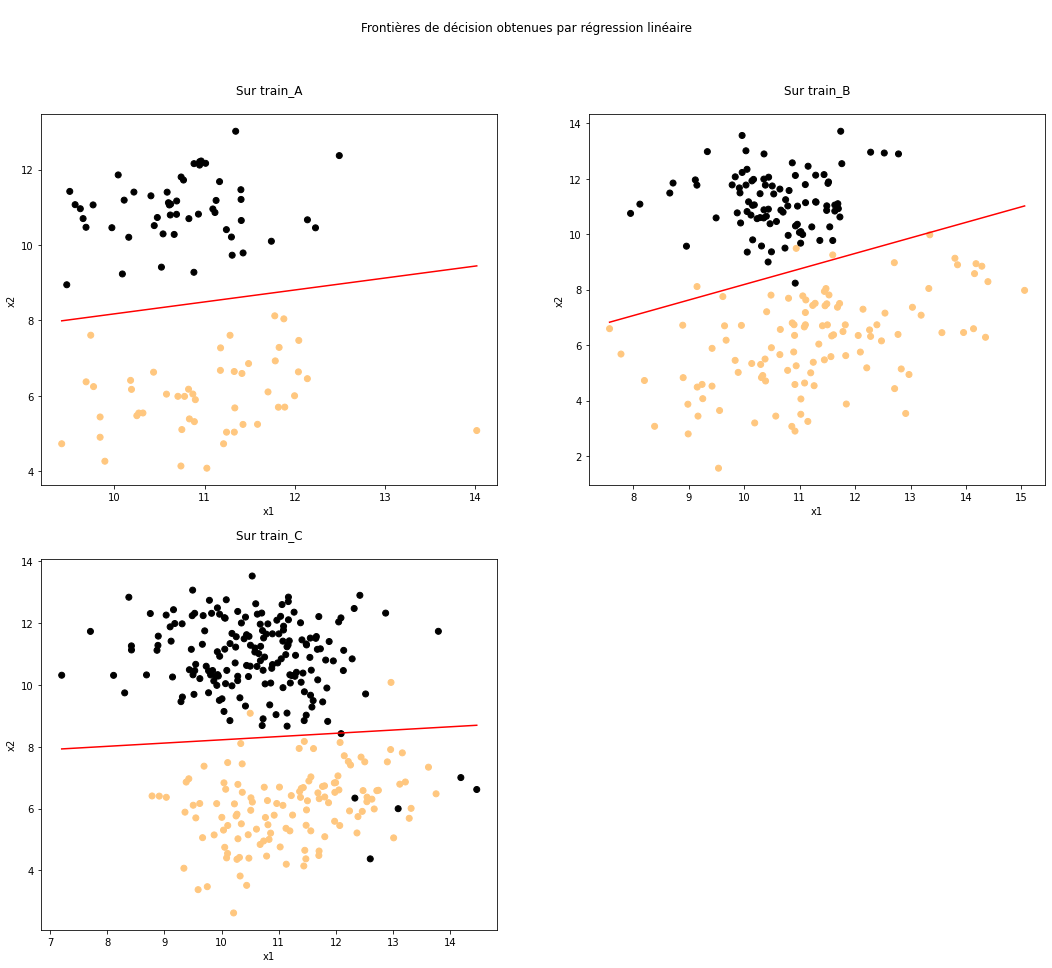

In [9]:
plt.figure(figsize=(18,15))

for i, letter in enumerate(['A', 'B', 'C']):
    
    plt.subplot(2,2,i+1)
    
    # Récupération des observations et des estimations
    x = x_train[letter]
    y = y_train[letter]
    beta = beta_lin[letter]
    
    # Nuage de points
    plt.scatter(x[:, 0], x[:, 1], c = y, cmap='copper')
    
    # Abscisses
    x1 = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
    
    # Calcul des points de la droite de décision
    x2 = (0.5 - (beta[0]+beta[1]*x1)) / beta[2]
    
    # Tracé de la droite
    plt.plot(x1, x2, color='red')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Sur train_{letter}\n')

plt.suptitle('\nFrontières de décision obtenues par régression linéaire')
plt.show()


### Réseau de neurones

#### Ajustement du modèle

On décide d'implémenter un réseau de neurones à 5 couches cachées, dont l'architecture est résumée ci-dessous :

                                                    
                      o   o                             Input : 3 entrées (x1, x2, biais) 

                  /           \

        o   o   o   o   o   o   o   o   o               C1 : 9 neurones, 3x9 poids

         \                             /                   -> Activation : Rectified Linear Unit (ReLU)

          o   o   o   o   o   o   o   o                 C2 : 8 neurones, 9x8 poids

            \                        /                     -> Activation : ReLU

            o   o   o   o   o   o   o                   C3 : 7 neurones, 8x7 poids

             \                    /                        -> Activation : ReLU

              o   o   o   o   o   o                     C4 : 6 neurones, 7x6 poids

               \                 /                         -> Activation : ReLU

                o   o   o   o   o                       C5 : 5 neurones, 6x5 poids

                  \            /                           -> Activation : sigmoïde

                        o                               Ouptut : une sortie

Chaque neurone contenu dans une couche cachée correspond à une matrice de poids qui sont appliqués aux données en entrée pour former une combinaison linéaire qu'on fournit à une fonction d'activation non-linéaire. L'activation obtenue par chaque neurone est ensuite donnée en entrée aux neurones de la couche suivante. L'imbrication successive des combinaisons linéaires et des activations permet ainsi en théorie d'approximer n'importe quelle fonction.

L'ajustement des poids se fait par rétro-propagation de l'erreur calculée au bout du réseau dans les couches antérieures.

Puisque nous faisons face à un problème de classification binaire, la dernière fonction d'activation correspond à la fonction logit ou sigmoïde que nous avons déjà croisée. La donnée en sortie est donc comprise entre 0 et 1, et peut s'interpréter comme la probabilité d'appartenir à la classe 1.

In [10]:
torch.manual_seed(42)

# Définition du modèle 

class NNReg(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.c1 = nn.Linear(2, 9)
        self.relu = nn.ReLU()
        self.c2 = nn.Linear(9, 8)
        self.c3 = nn.Linear(8, 7)
        self.c4 = nn.Linear(7, 6)
        self.c5 = nn.Linear(6, 5)
        self.out = nn.Linear(5, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.c1(x))
        x = self.relu(self.c2(x))
        x = self.relu(self.c3(x))
        x = self.relu(self.c4(x))
        x = self.relu(self.c5(x))
        x = self.sigmoid(self.out(x))
        return x


In [11]:
NN = {}

for letter in ['A', 'B', 'C']:
    print(f'\nAjustement sur train{letter}\n')
    
    # Transformation de nos arrays en tensors
    x = torch.from_numpy(x_train[letter]).type(torch.float32)
    y = torch.from_numpy(y_train[letter]).type(torch.float32).unsqueeze(1)
    
    train_split = int(0.8*len(x))
    # Ensemble d'apprentissage
    X_t, y_t = x[:train_split], y[:train_split]
    # Ensemble de validation
    X_v, y_v = x[train_split:], y[train_split:]

    test_loss_values = []
    model_states = []
    
    model = NNReg()
    
    # Fonction de perte : cross-entropy binaire
    perte = nn.BCEWithLogitsLoss()
    # Algorithme d'optimisation
    opti = optim.SGD(model.parameters(), lr=.5)
    # Nombre d'itérations
    epochs = 3000
    
    for epoch in range(epochs+1):
        
        # Mode 'apprentissage'
        model.train()
        # Forward pass
        y_pred = model.forward(X_t)
        # Calcul de l'exactitude (taux d'erreur)
        acc = torch.sum(torch.round(y_pred)==y_t)/len(X_t)
        # Calcul de la perte
        loss = perte(y_pred, y_t)
        # Mise à 0 du gradient
        opti.zero_grad()
        # Rétro-propagation de l'erreur
        loss.backward()
        opti.step()

        # Mode 'évaluation'
        model.eval()

        with torch.inference_mode():
            # Prédiction sur les données de validation
            test_pred = model(X_v)
            # Exactitude de la prédiction sur les données de valudation
            test_acc = torch.sum(torch.round(test_pred)==y_v)/len(X_v)
            # Perte
            test_loss = perte(test_pred, y_v.type(torch.float))
            # Enregistrement du score de perte
            test_loss_values.append(test_loss.detach().numpy())
           
        # Suivi de l'ajustement
        if epoch % 500 == 0:
            print(f"Epoch: {epoch} | BCE Train: {loss} | BCE Test: {test_loss} | Acc Train: {acc} | Acc Test {test_acc}")
            
        model_states.append(model)
        
    # On retient l'état du modèle ayant obtenu le meilleur score sur l'ensemble de test    
    NN[letter] = model_states[np.argmin(test_loss_values)]


Ajustement sur trainA

Epoch: 0 | BCE Train: 0.7153794169425964 | BCE Test: 0.8351849317550659 | Acc Train: 0.5249999761581421 | Acc Test 0.30000001192092896
Epoch: 500 | BCE Train: 0.4939139485359192 | BCE Test: 0.5799342393875122 | Acc Train: 1.0 | Acc Test 1.0
Epoch: 1000 | BCE Train: 0.4937591552734375 | BCE Test: 0.5794557332992554 | Acc Train: 1.0 | Acc Test 1.0
Epoch: 1500 | BCE Train: 0.49373388290405273 | BCE Test: 0.5793446898460388 | Acc Train: 1.0 | Acc Test 1.0
Epoch: 2000 | BCE Train: 0.49372434616088867 | BCE Test: 0.5792967081069946 | Acc Train: 1.0 | Acc Test 1.0
Epoch: 2500 | BCE Train: 0.49371957778930664 | BCE Test: 0.5792702436447144 | Acc Train: 1.0 | Acc Test 1.0
Epoch: 3000 | BCE Train: 0.4937167763710022 | BCE Test: 0.5792534947395325 | Acc Train: 1.0 | Acc Test 1.0

Ajustement sur trainB

Epoch: 0 | BCE Train: 0.6999484896659851 | BCE Test: 0.6634612083435059 | Acc Train: 0.46875 | Acc Test 0.375
Epoch: 500 | BCE Train: 0.5125885605812073 | BCE Test: 0.480950

#### Représentation graphique

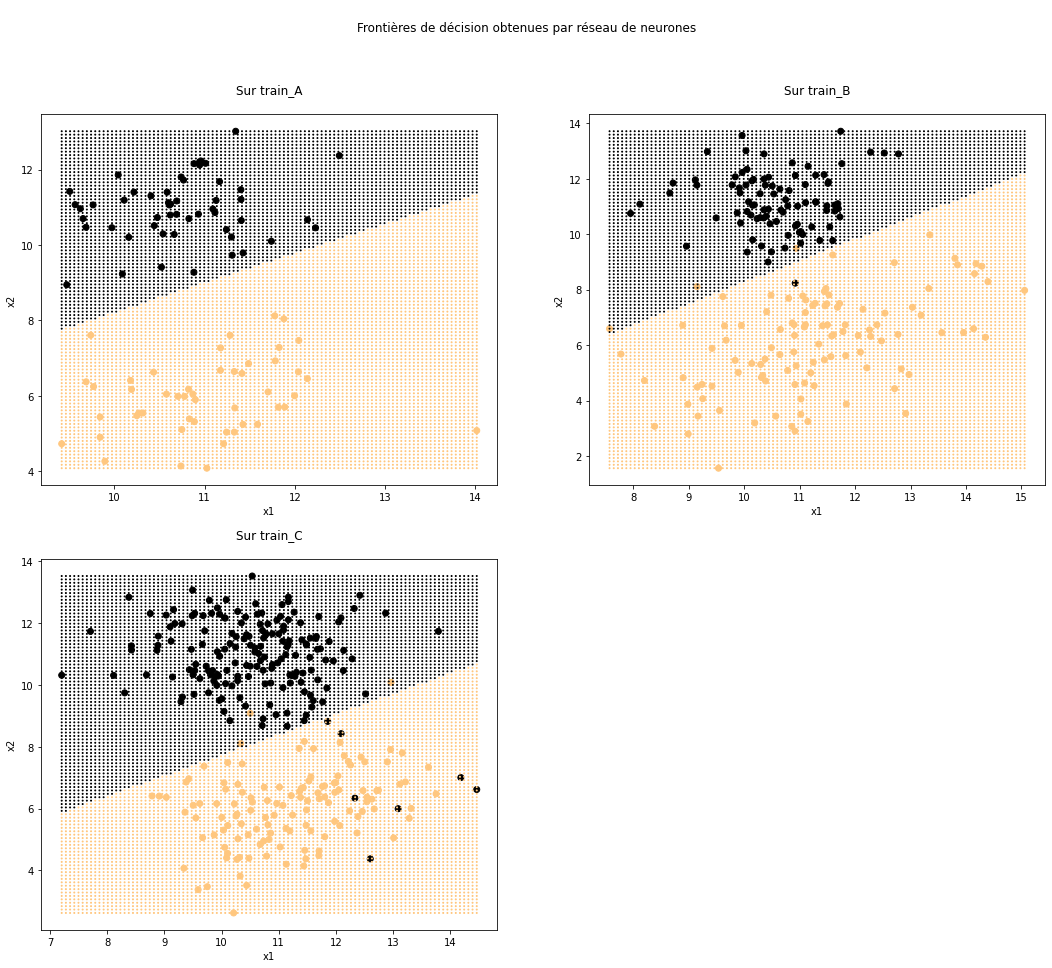

In [12]:
plt.figure(figsize=(18,15))

for i, letter in enumerate(['A', 'B', 'C']):
    
    plt.subplot(2,2,i+1)
    
    # Récupération des observations et des estimations
    x = x_train[letter]
    y = y_train[letter]
    
    # Nuage de points
    plt.scatter(x[:, 0], x[:, 1], c = y, cmap='copper')
    
    # Création d'une grille de coordonnées
    x1 = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
    x2 = np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 100)
    grid1, grid2 = np.meshgrid(x1, x2)
    grid = np.array([np.ravel(grid1), np.ravel(grid2)]).T
    # Prédiction de la classe de l'ensemble des points de la grille
    crit = NN[letter](torch.from_numpy(grid).type(torch.float32)) > .5
    
    # Visualisation des zones découpées par la fonction P(Y=1|X=x) = 0.5
    plt.scatter(grid[:,0], grid[:,1], c = crit, cmap='copper', s=1)
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Sur train_{letter}\n')

plt.suptitle('\nFrontières de décision obtenues par réseau de neurones')
plt.show()

### Application sur les données de test

In [13]:
# Fonctions pour la prédiction
predict_lda = lambda x, letter: lda(x[letter], letter) > 0
predict_lin = lambda x, letter: np.concatenate([np.ones((len(x[letter]), 1)), x[letter]], axis=1)@beta_lin[letter] > 0.5
predict_log = lambda x, letter: g(np.concatenate([np.ones((len(x[letter]), 1)), x[letter]], axis=1)@beta_log[letter]) > .5
def predict_NN(x, letter): 
    pred = NN[letter](torch.from_numpy(x[letter]).type(torch.float32)) > .5
    return pred.squeeze().numpy()

# Fonction de calcul de l'erreur de classification
erreur = lambda x, y, pred, letter: round(np.mean(abs(pred(x, letter) - y[letter])), 2)

In [14]:
err_lda = {}
err_lin = {}
err_log = {}
err_NN = {}

for letter in ['A', 'B', 'C']:
    err_lda['train'+letter] = erreur(x_train, y_train, predict_lda, letter)
    err_lda['test'+letter] = erreur(x_test, y_test, predict_lda, letter)
    err_lin['train'+letter] = erreur(x_train, y_train, predict_lin, letter)
    err_lin['test'+letter] = erreur(x_test, y_test, predict_lin, letter)
    err_log['train'+letter] = erreur(x_train, y_train, predict_log, letter)
    err_log['test'+letter] = erreur(x_test, y_test, predict_log, letter)
    err_NN['train'+letter] = erreur(x_train, y_train, predict_NN, letter)
    err_NN['test'+letter] = erreur(x_test, y_test, predict_NN, letter)

pd.DataFrame([err_lda, err_log, err_lin, err_NN]).rename(mapper={
    0:'Analyse discriminante', 
    1:'Régression logistique', 
    2:'Régression linéaire', 
    3:'Réseau de neurones'}, axis=0)

trainA  testA  trainB  testB  trainC  testC
Analyse discriminante     0.0   0.01    0.02   0.04    0.03   0.04
Régression logistique     0.0   0.02    0.01   0.04    0.03   0.05
Régression linéaire       0.0   0.01    0.02   0.04    0.03   0.04
Réseau de neurones        0.0   0.02    0.02   0.04    0.03   0.04

Ce tableau montre les taux d'erreurs obtenus par nos quatre modèles et nous apporte plusieurs informations :
- les quatre méthodes de classification que nous avons détaillées donnent des résultats extrêmement proches ;
- la proximité des scores d'exactitude entre données d'apprentissage et de test semble indiquer qu'il n'y a pas eu de surajustement excessif ;
- les données issues de l'ensemble A sont plus faciles à distinguer (1%-2% d'erreurs de test) que celles des ensembles B ou C (~4% d'erreurs), la raison étant que ces données sont séparables linéairement de façon quasi parfaite (comme on a pu le constater graphiquement).

Avec les données dont nous disposons et les règles de décision que nous avons appliquées, il n'est pas surprenant que les trois modèles linéaires - analyse discriminante, régression logistique et régression linéaire - aient fourni des résultats similaires. 

Le réseau de neurones, en revanche, aurait théoriquement pu mieux faire que ces derniers puisqu'il devrait être en mesure d'approximer une frontière de décision non-linéaire qui épouserait mieux les contours des deux classes représentées dans les datasets A et B. Puisque nous avons obtenu une frontière linéaire cependant (peut-être est-ce dû à la nature et la quantité des données utilisées, à l'architecture imposée ou à une paramétrisation sous-optimale de notre modèle), ses performances sont comparables à celles des modèles précédents.

Ces résultats montrent bien que les modèles à base de réseaux de neurones ne sont pas toujours les plus pertinents à utiliser. En fonction de la nature et de la quantité des données fournies ou des contraintes imposées (vitesse de déploiement, interprétabilité...), il peut être plus avantageux de recourir à des modèles d'apprentissage plus simples tels que ceux que nous venons d'étudier.

## Modèle de mélange gaussien et algorithme EM

### Préparation des données

In [18]:
#pip install pyreadr
import pyreadr
from sklearn.preprocessing import StandardScaler

In [19]:
# Importation
decat = pyreadr.read_r(path+"decathlon.RData")
# Extraction du dataframe
decat = decat['X']
decat.head(10)

100m  Long.jump  Shot.put  High.jump   400m  110m.hurdle  Discus  \
rownames                                                                       
SEBRLE     11.04       7.58     14.83       2.07  49.81        14.69   43.75   
CLAY       10.76       7.40     14.26       1.86  49.37        14.05   50.72   
KARPOV     11.02       7.30     14.77       2.04  48.37        14.09   48.95   
BERNARD    11.02       7.23     14.25       1.92  48.93        14.99   40.87   
YURKOV     11.34       7.09     15.19       2.10  50.42        15.31   46.26   
WARNERS    11.11       7.60     14.31       1.98  48.68        14.23   41.10   
ZSIVOCZKY  11.13       7.30     13.48       2.01  48.62        14.17   45.67   
McMULLEN   10.83       7.31     13.76       2.13  49.91        14.38   44.41   
MARTINEAU  11.64       6.81     14.57       1.95  50.14        14.93   47.60   
HERNU      11.37       7.56     14.41       1.86  51.10        15.06   44.99   

           Pole.vault  Javeline  1500m  
rownames                                
SEBRLE           5.02     63.19  291.7  
CLAY             4.92     60.15  301.5  
KARPOV           4.92     50.31  300.2  
BERNARD          5.32     62.77  280.1  
YURKOV           4.72     63.44  276.4  
WARNERS          4.92     51.77  278.1  
ZSIVOCZKY        4.42     55.37  268.0  
McMULLEN         4.42     56.37  285.1  
MARTINEAU        4.92     52.33  262.1  
HERNU            4.82     57.19  285.1

In [20]:
# Normalisation
disciplines = decat.columns
decat = pd.DataFrame(StandardScaler().fit(decat).transform(decat))
decat.columns = disciplines
decat.head(10)

100m  Long.jump  Shot.put  High.jump      400m  110m.hurdle    Discus  \
0  0.161478   1.023937  0.433405   1.060457  0.169981     0.180572 -0.172524   
1 -0.916293   0.447972 -0.266573  -1.329735 -0.216222    -1.192819  1.916555   
2  0.084494   0.127992  0.359723   0.719001 -1.093956    -1.106982  1.386043   
3  0.084494  -0.095994 -0.278853  -0.646823 -0.602425     0.824348 -1.035731   
4  1.316232  -0.543966  0.875496   1.401913  0.705398     1.511044  0.579784   
5  0.430920   1.087933 -0.205171   0.036089 -0.821859    -0.806553 -0.966794   
6  0.507904   0.127992 -1.224437   0.377545 -0.874523    -0.935308  0.402947   
7 -0.646850   0.159990 -0.880588   1.743369  0.257754    -0.484665  0.025294   
8  2.470986  -1.439911  0.114117  -0.305367  0.459633     0.695593  0.981415   
9  1.431707   0.959941 -0.082368  -1.329735  1.302257     0.974563  0.199134   

   Pole.vault  Javeline     1500m  
0    0.937988  1.022196  1.099316  
1    0.573807  0.384558  1.949271  
2    0.573807 -1.679377  1.836522  
3    2.030532  0.934101  0.093246  
4   -0.154555  1.074633 -0.227656  
5    0.573807 -1.373143 -0.080215  
6   -1.247098 -0.618045 -0.956190  
7   -1.247098 -0.408295  0.526896  
8    0.573807 -1.255683 -1.467898  
9    0.209626 -0.236301  0.526896

### Clustering à l'aide de GMM

In [21]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

La première étape consiste à trouver le nombre de composantes, c'est-à-dire le nombre de clusters contenus dans nos données ou encore le nombre de gaussiennes impliquées dans le mélange. Il s'agit d'un hyperparamètre de l'implémentation des GMM sous Scikit-Learn, au même titre que le type de covariance à estimer.

Pour optimiser ces deux paramètres, on peut recourir au critère du BIC (*Bayesian Information Criterium*). La démarche consiste à ajuster le modèle des mélanges gaussiens sur nos données avec différentes combinaisons d'hyperparamètres, d'extraire le BIC puis de sélectionner le type de covariance et le nombre de composantes ayant obtenu ensemble le plus petit score.

Les graphiques ci-dessous montrent l'évolution de l'AIC et du BIC du modèle pour différentes valeurs de `n_components`.

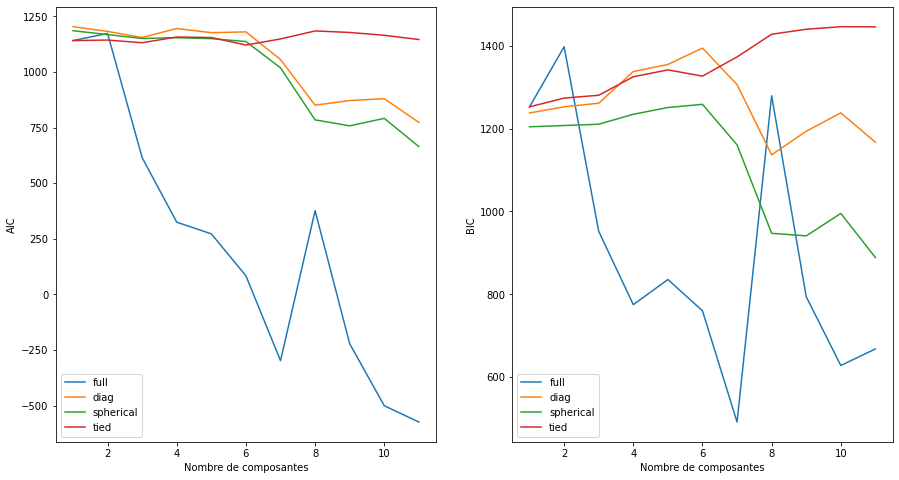

Meilleur score du BIC trouvé pour 7 composantes


In [22]:
n_components = np.arange(1, 12)

AIC = {}
BIC = {}
L_crit = {}
for cov_type in ['full', 'diag', 'spherical', 'tied']:
    models = [GMM(n, covariance_type=cov_type, random_state=42).fit(decat) for n in n_components]
    BIC[cov_type]=[m.bic(decat) for m in models]
    AIC[cov_type]=[m.aic(decat) for m in models]

L_crit['BIC'] = BIC
L_crit['AIC'] = AIC

plt.figure(figsize=(15, 8))
for i, crit in enumerate(['AIC', 'BIC']):
    plt.subplot(1, 2, i+1)
    for cov_type in ['full', 'diag', 'spherical', 'tied']:
        plt.plot(n_components, L_crit[crit][cov_type], label=cov_type)
    plt.legend(loc='best')
    plt.xlabel('Nombre de composantes')
    plt.ylabel(crit)
plt.show()

best_k = np.argmin(L_crit['BIC']['full'])+1
print(f'Meilleur score du BIC trouvé pour {best_k} composantes')

Suivant cette logique, il faudrait donc qu'on retienne un modèle à 7 composantes et une covariance libre pour le clustering par GMM.

In [23]:
gmm = GMM(n_components=best_k, covariance_type='full', init_params='kmeans')
gmm.fit(decat)
clust =  gmm.predict(decat)
clust

array([1, 1, 1, 6, 4, 6, 2, 2, 4, 4, 4, 3, 4, 5, 5, 2, 2, 6, 2, 2, 6, 2,
       6, 1, 6, 4, 2, 6, 6, 3, 3, 6, 4, 1, 3, 4, 3, 4, 1, 3, 0],
      dtype=int64)

On voit ci-dessus que chaque observation est associée à l'un des 7 clusters détectés.

Les graphiques ci-dessous montrent qu'il est difficile d'identifier les critères sur lesquels se basent ce regroupement des individus par une simple projection le plan formé par deux variables.

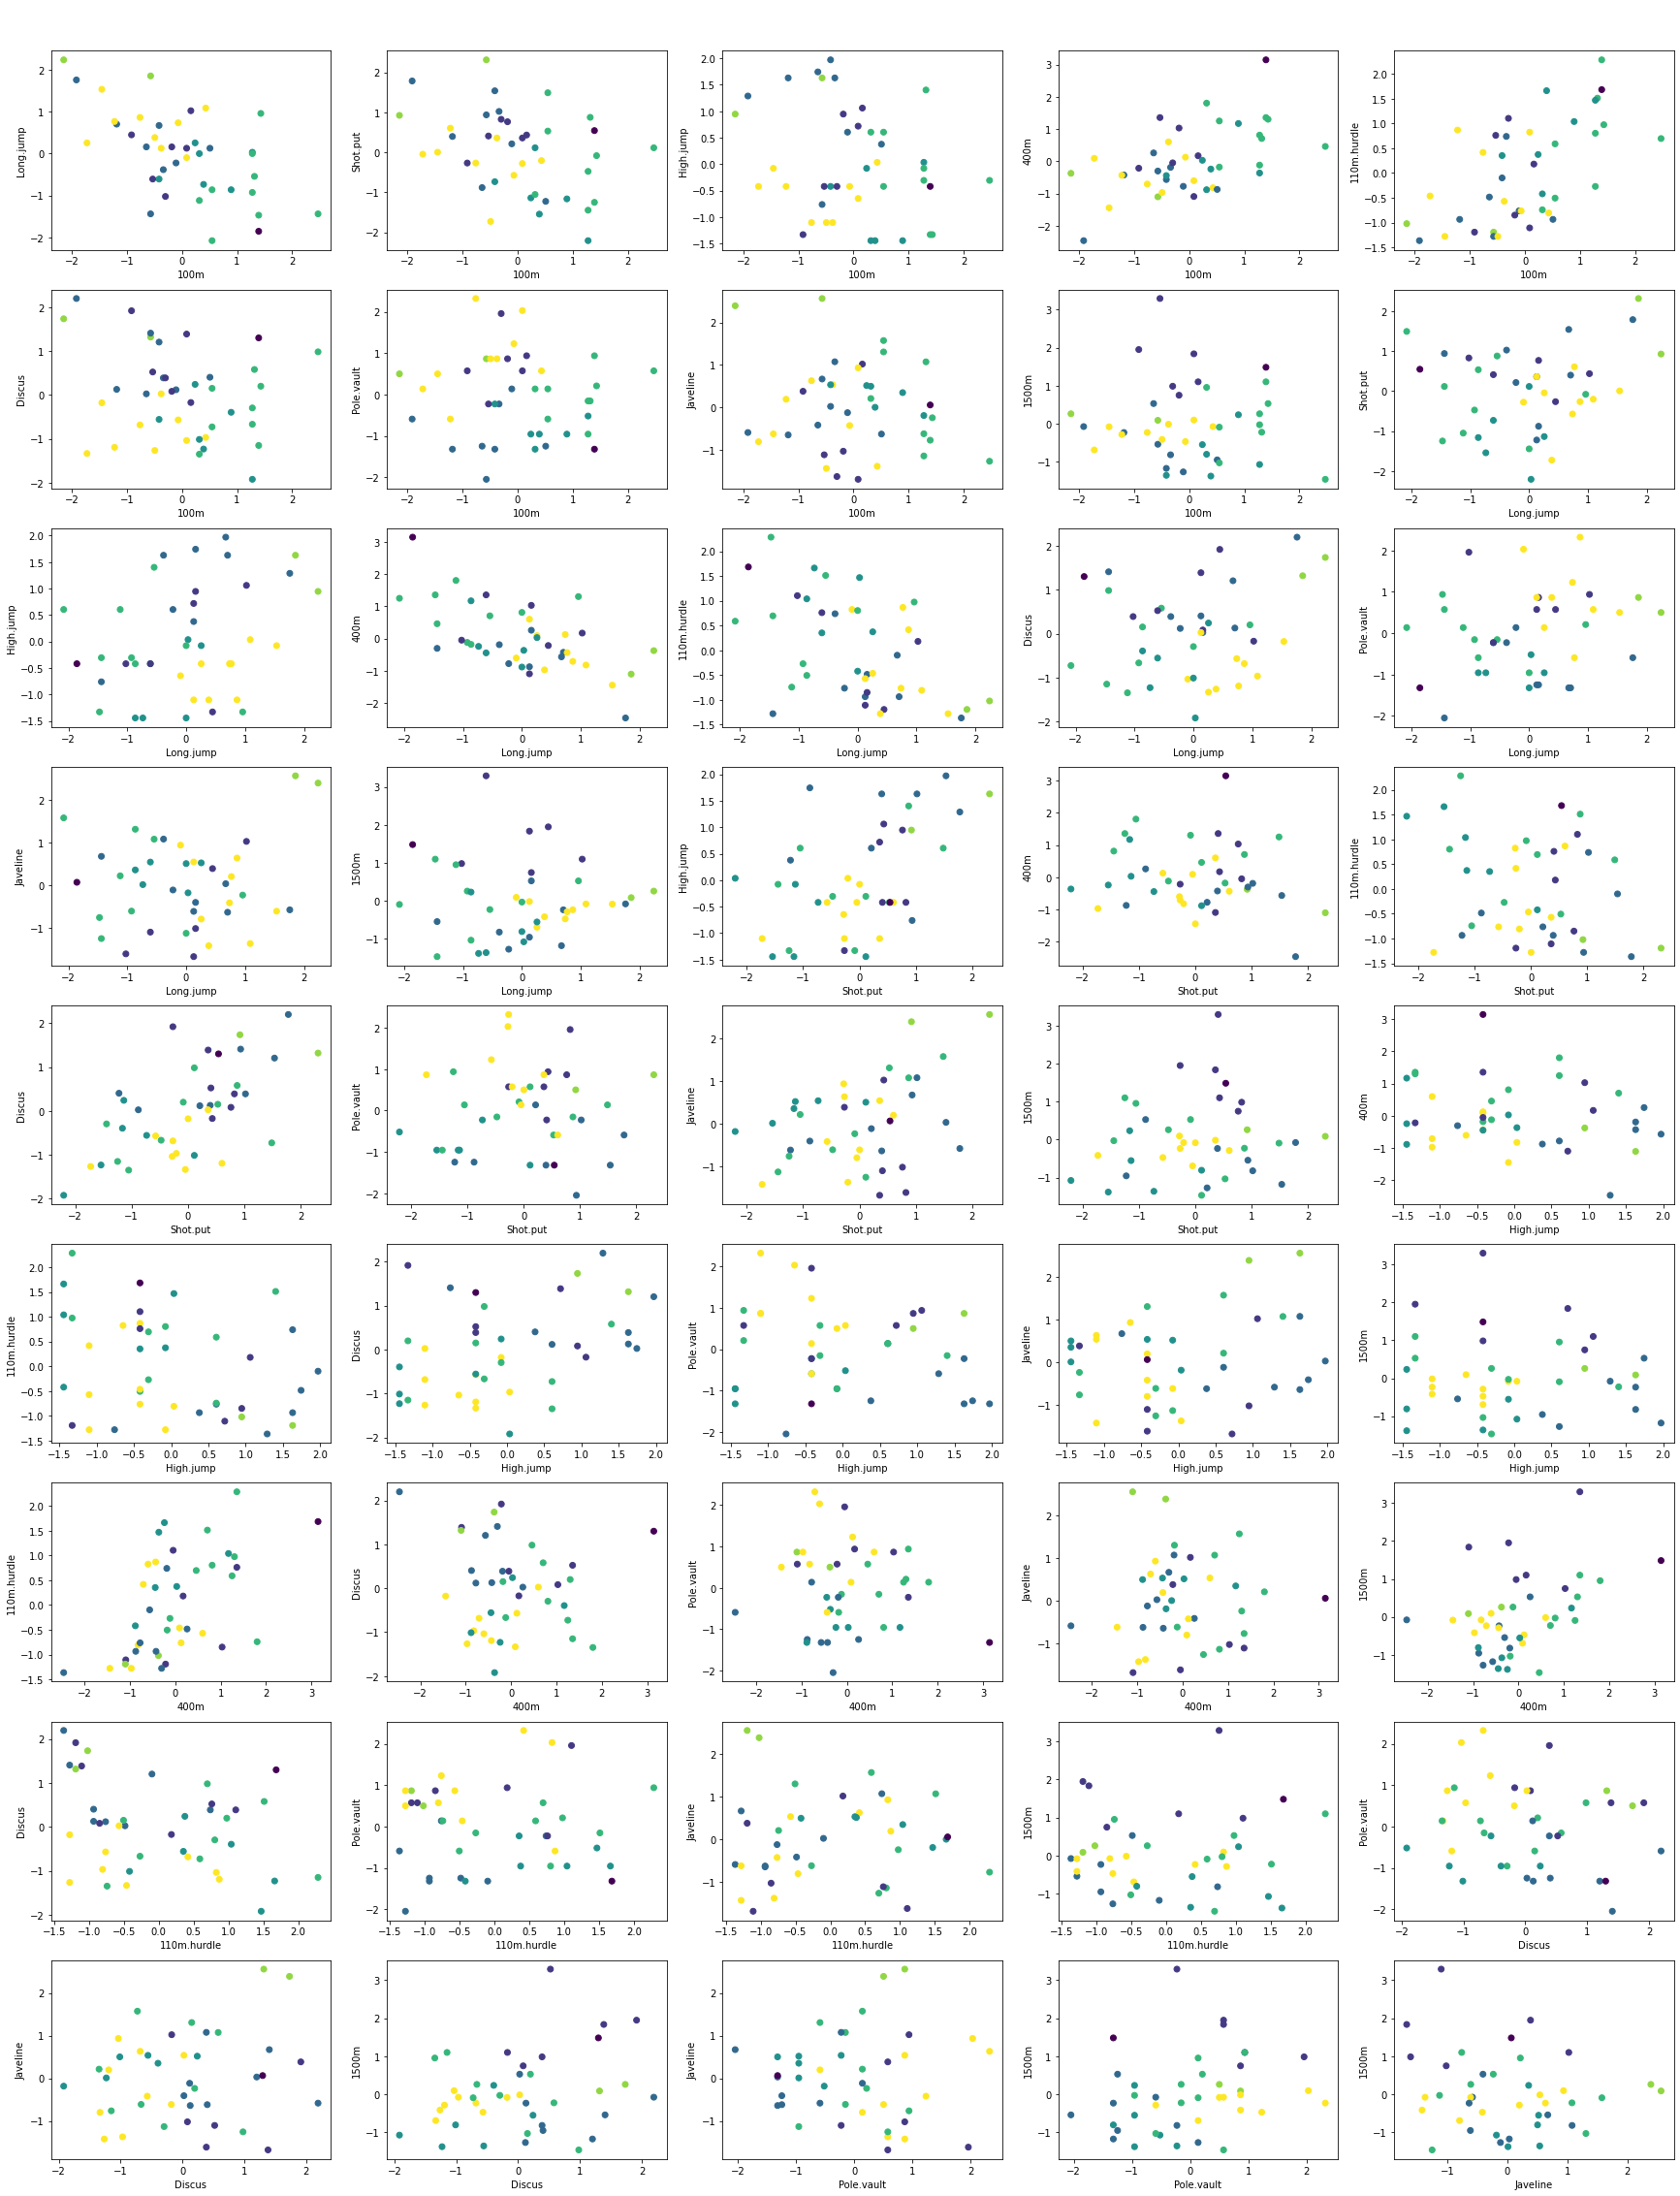

In [24]:
plt.figure(figsize=(30,40))
rg = 0

for i in range(10):
    for j in range(i+1, 10):
        rg += 1
        plt.subplot(9,5,rg)
    
    # Récupération des observations et des estimations
        x = decat.iloc[:,i]
        y = decat.iloc[:,j]

        # Nuage de points
        plt.scatter(x, y, c=clust, cmap='viridis')

        

        plt.xlabel(disciplines[i])
        plt.ylabel(disciplines[j])
        plt.title('\n\n')

plt.show()

Une approche classique pour nous aider à visualiser les clusters obtenus consisterait à utiliser une technique de réduction de la dimensionnalité telle que l'analyse en composantes principales (ACP). En se basant sur la corrélation entre variables, cette dernière permet de forger des variables synthétiques sous forme de combinaisons linéaires des variables initiales : il est ensuite loisible de projeter les observations dans l'espace des nouvelles variables.

On décide ici d'extraire 3 composantes à partir de l'ACP afin de réaliser une projection dans l'espace de nos observations et identifier un peu mieux les clusters obtenus.

In [25]:
acp = PCA(n_components = 3)
acp.fit(decat)
acp.components_
# Création d'une version réduite à 3 variables du dataset initial
decat_red = acp.transform(decat)
acp.components_

array([[-0.42829627,  0.41015201,  0.34414444,  0.31619436, -0.3757157 ,
        -0.41255442,  0.30542571,  0.02783081,  0.15319802, -0.03210733],
       [ 0.14198909, -0.26207936,  0.45394697,  0.2657761 ,  0.432046  ,
         0.17359096,  0.4600244 , -0.13684105,  0.24050715,  0.35980486],
       [-0.15557953,  0.15372674, -0.01972378, -0.21894349,  0.11091758,
        -0.07815576,  0.0362377 ,  0.58361717, -0.32874217,  0.65987362]])

A quoi correspond chaque composante ? Le vecteur ci-dessous nous donne les poids associés par chaque composant aux variables initiales. En appliquant une règle, on peut essayer de retrouver quelles variables sont associées ou opposées par l'axe créé.

In [26]:
disciplines[np.argwhere(acp.components_[0]>0.2)]

array([['Long.jump'],
       ['Shot.put'],
       ['High.jump'],
       ['Discus']], dtype=object)

In [27]:
disciplines[np.argwhere(acp.components_[0]< (-0.2))]

array([['100m'],
       ['400m'],
       ['110m.hurdle']], dtype=object)

Le premier axe semble ainsi associer résultats des épreuves de saut et de lancer et les opposer aux épreuves de course.

Pour décrypter les nouveaux axes, on peut également se référer à la matrice de corrélation entre les variables initiales.

<AxesSubplot:>

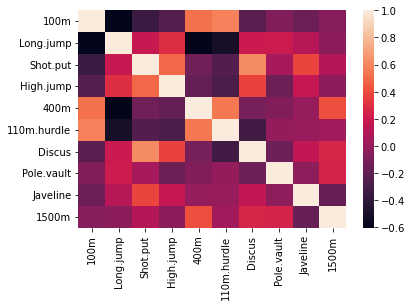

In [28]:
sea.heatmap(decat.corr())

In [29]:
import plotly.express as px
import plotly.graph_objects as go

In [30]:
fig = px.scatter_3d(x=decat_red[:,0], y=decat_red[:,1], z=decat_red[:,2], color=clust)
fig.update_traces(marker=dict(size=6),
                  selector=dict(mode='markers'))
fig.update_layout(scene = dict(xaxis = dict(nticks=5, range=[-6,6]),
                                yaxis = dict(nticks=5, range=[-6,6]),
                                zaxis = dict(nticks=5, range=[-6,6])),
                  scene_aspectmode='cube')
fig.show()